In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


# EDA on Yu-Gi-Oh!
In this notebook we'll use information on the entire collection to try and get some insight on how Yu-Gi-Oh! TCG has evolved throughout the years.

## Loading the data
We start by loading the data. The **cards.csv** file contains the entire catalog of Yu-Gi-Oh! cards.

In [2]:
cards = pd.read_csv("/kaggle/input/yugioh-cards/cards.csv")
print(f"Number of cards in the catalog: {cards.shape[0]}")

Number of cards in the catalog: 12451


The **cardsets.csv** file contains information on Yu-Gi-Oh! sets. In a simplified manner, sets are just a group of cards. You open *booster packs* from a set to get cards from that set's card pool.

In [3]:
sets = pd.read_csv("/kaggle/input/yugioh-cards/cardsets.csv")
print(f"Number of sets: {sets.shape[0]}")
print("Some examples of Yu-Gi-Oh! sets:")
for row in sets.sample(3, random_state=0).itertuples():
    print(f'\t\"{row.set_name}\" released with {row.num_of_cards} cards on {row.tcg_date} on the TCG')

Number of sets: 938
Some examples of Yu-Gi-Oh! sets:
	"Generation Force" released with 100 cards on 2011-08-16 on the TCG
	"Shonen Jump Vol. 1, Issue 1 promotional card" released with 1 cards on 2002-11-26 on the TCG
	"The Lost Art Promotion 2020 I" released with 1 cards on 2020-07-15 on the TCG


The **card_variants.csv** file contains information about the alternative arts of some cards.

There are 161 alternative card arts
Here's an example:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  


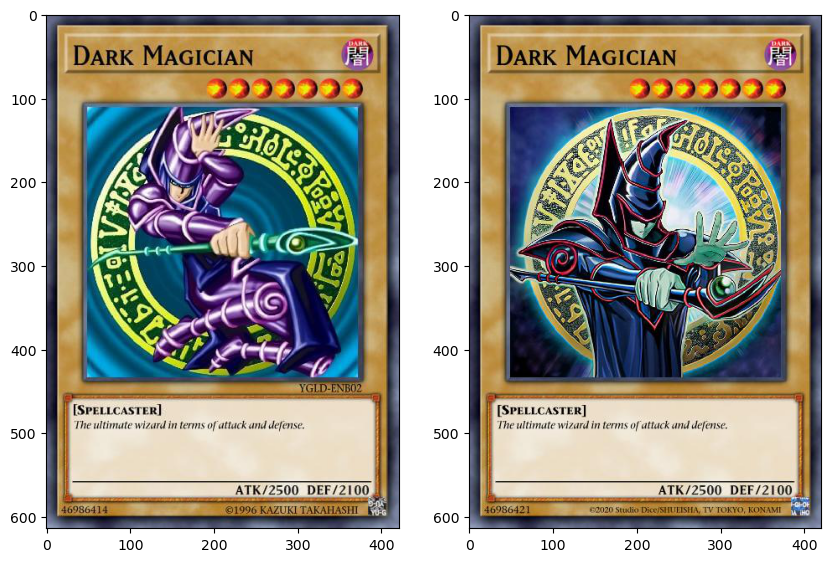

In [4]:
alt_arts = pd.read_csv("/kaggle/input/yugioh-cards/cards_variants.csv")
print(f"There are {alt_arts.shape[0]} alternative card arts")
print("Here's an example:")

fig, ax = plt.subplots(1, 2, figsize=(10, 20))
original, alternative = alt_arts.sample(random_state=12).iloc[0].values
ax[0].imshow(plt.imread(f'https://images.ygoprodeck.com/images/cards/{original}.jpg', format="jpeg"))
ax[1].imshow(plt.imread(f'https://images.ygoprodeck.com/images/cards/{alternative}.jpg', format="jpeg"))

The **cards_cardsets.csv** file contains information that maps cards to the respective sets they were released in. There are more entries in this file than cards in the catalog because a card can be part of multiple sets (reprinted). Yu-Gi-Oh! does not have set rotation, meaning that anything that gets printed and isn't on the banlist can be played, so reprints offer a new supply of older cards.

In [5]:
card_to_set = pd.read_csv("/kaggle/input/yugioh-cards/cards_cardsets.csv")
print(f"Total number of entries: {card_to_set.shape[0]}")

Total number of entries: 34056


## Preprocessing and cleaning
To consider reprints in the analysis, we'll have to merge some of those datasets, as that information is not available in the **cards** dataset.

In [6]:
df = cards.merge(card_to_set, how="right", left_on="id", right_on="card_id", validate="1:m").merge(sets, how="left", left_on="set_id", right_on="id")

In [7]:
pd.set_option("max_columns", 39)

We'll drop features that won't be interesting for the analysis and give more meaningful names to some columns.

In [8]:
df = df.drop(columns=["id_x", "id_y", "image_url_small", "image_url", "num_of_cards", "set_id", "ocg_date", "ban_tcg", "ban_ocg", "ban_goat", "konami_id", "treated_as"])
df = df.rename(columns={"tcg_date_x": "first_print", "tcg_date_y": "release_date", "set_code_y": "set_prefix", "set_code_x": "card_code_in_set"})

# just reordering
df = df[["name", "card_id", "type", "desc", "atk", "def", "level", "race", "attribute", "scale", "archetype", "linkval", "linkmarkers", "staple", "views",
       "viewsweek", "upvotes", "downvotes", "first_print", "release_date", "formats", "set_name", "set_prefix", "card_code_in_set", "set_rarity",
       "set_rarity_code"]]

Converting columns to the appropriate datatype.

In [9]:
df["release_date"] = pd.to_datetime(df["release_date"], format="%Y-%m-%d", errors="coerce")
df["first_print"] = pd.to_datetime(df["first_print"], format="%Y-%m-%d", errors="coerce")

In [10]:
df["staple"] = df["staple"].map({"Yes": 1}).fillna(0).astype(np.int8)

Removing tokens and skill cards.

In [11]:
df = df[~df["type"].isin(["Token", "Skill Card"])]

Removing cards that are yet to be released on the TCG

In [12]:
df = df[df["release_date"] < pd.to_datetime("today")]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33845 entries, 0 to 34055
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              33845 non-null  object        
 1   card_id           33845 non-null  int64         
 2   type              33845 non-null  object        
 3   desc              33845 non-null  object        
 4   atk               21610 non-null  float64       
 5   def               20884 non-null  float64       
 6   level             20884 non-null  float64       
 7   race              33845 non-null  object        
 8   attribute         21610 non-null  object        
 9   scale             619 non-null    float64       
 10  archetype         17887 non-null  object        
 11  linkval           726 non-null    float64       
 12  linkmarkers       726 non-null    object        
 13  staple            33845 non-null  int8          
 14  views             3384

We still have a lot of NaN values, but those make sense (e.g. spell cards with an NaN atk value)

## Investigating the data

There are some questions that I'd like to investigate using the data we have.

* Which attribute type has the most amount of supporting cards?
* What are some of the most loved/hated cards?
* When did special summoning started gaining popularity?


### Which attribute has the most amount of support?

For starters let's get an overall view of the attribute distribution in the dataset (making sure to discard reprints from the analysis).

<AxesSubplot:xlabel='attribute', ylabel='count'>

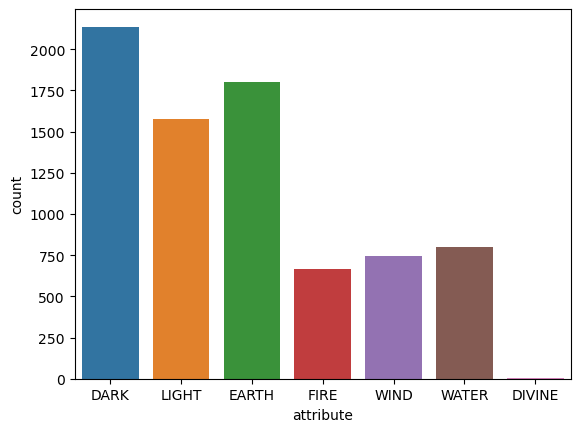

In [14]:
df_unique = df.drop_duplicates("card_id")
sns.countplot(x="attribute", data=df_unique)

The attribute is indicated at the top right on a monster card (spell and traps don't have attributes). The most represented attribute apparently is DARK, with EARTH as a somewhat close second. I honestly expected LIGHT and DARK to be closer together at the top, as they have all the *Chaos* cards (series of cards that interact with LIGHTs and DARKs) and are the attributes of *Dark Magician* and *Blue Eyes White Dragon*, two of the most popular monsters (this may be proven wrong later in the analysis).

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL f

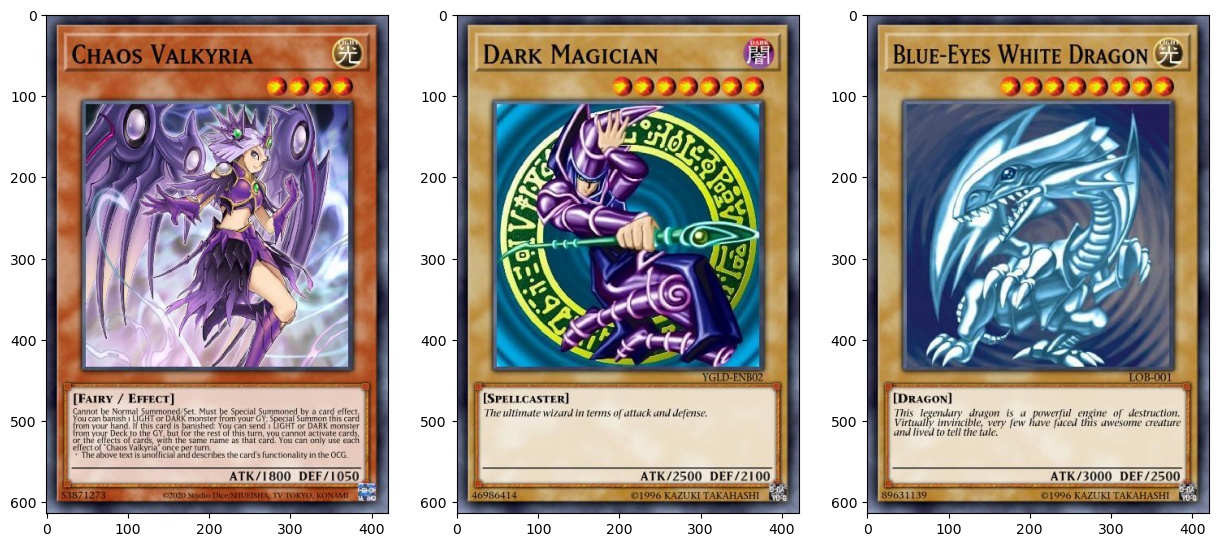

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 30))
ax[0].imshow(plt.imread('https://images.ygoprodeck.com/images/cards/53871273.jpg', format="jpeg"))
ax[1].imshow(plt.imread('https://images.ygoprodeck.com/images/cards/46986414.jpg', format="jpeg"))
ax[2].imshow(plt.imread('https://images.ygoprodeck.com/images/cards/89631139.jpg', format="jpeg"))

Let's investigate how the attribute distribution evolved throughout the years.

In [16]:
attr_by_year = df_unique.groupby(df_unique["first_print"].dt.year)["attribute"].value_counts()

# fill in years that didn't have any cards from an attribute printed
for year in range(2001, 2024):
    for attribute in ("WATER", "FIRE", "EARTH", "WIND", "DARK", "LIGHT", "DIVINE"):
        if (year, attribute) not in attr_by_year:
            attr_by_year[(year, attribute)] = 0
attr_by_year = attr_by_year.to_frame().rename(columns={"attribute": "num_cards"}).reset_index().rename(columns={"first_print": "year"})

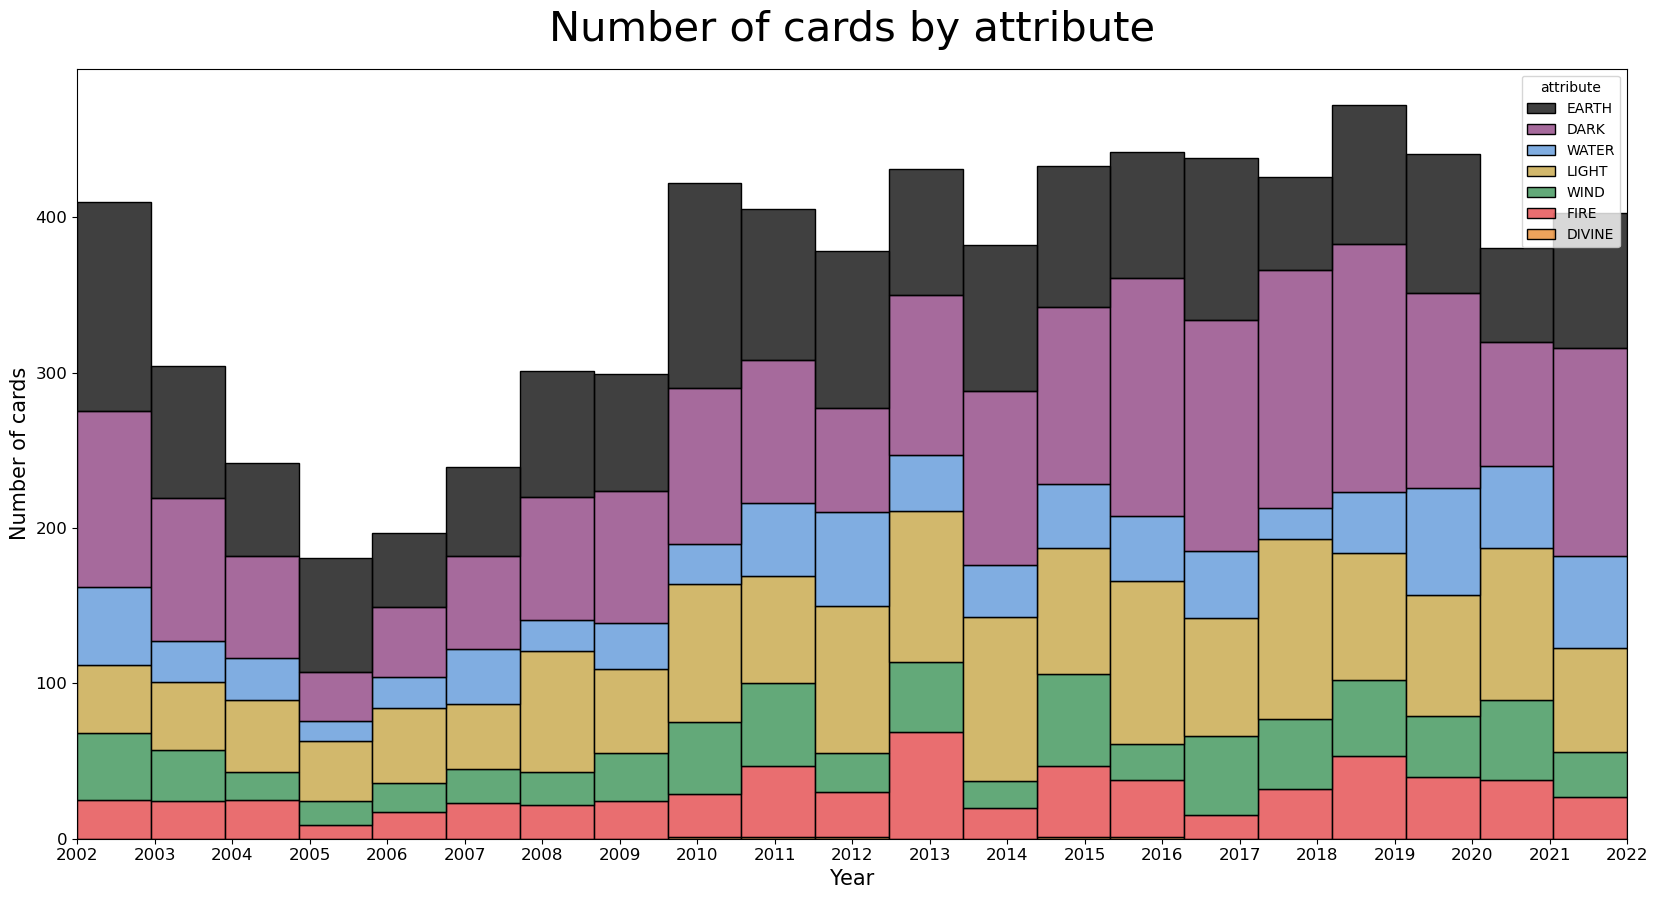

In [17]:
plt.figure(figsize=(20,10))
g = sns.histplot(data=attr_by_year[attr_by_year["year"].between(2002, 2022)], x="year", weights="num_cards", hue="attribute", palette=["black", "#89387b", "#5592d8", "#c3a03b", "#2f8c4c", "#e23e40", "#e88525"], multiple="stack", bins=21)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=21))
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(ymin=0)
ax.margins(x=0)

ax.set_title("Number of cards by attribute", fontsize=30, pad=20)
ax.set_ylabel("Number of cards", fontsize=15)
ax.set_xlabel("Year", fontsize=15)

 
plt.show()

The figure above tells us that the amount of cards printed per year started at about 400 in 2002, dipped until 2005, and then started rising again until it stabilized in 400ish after a spike in the number of cards printed in 2010. Looking at the picture, however it isn't easy to compare each attribute with the others. We can do better.

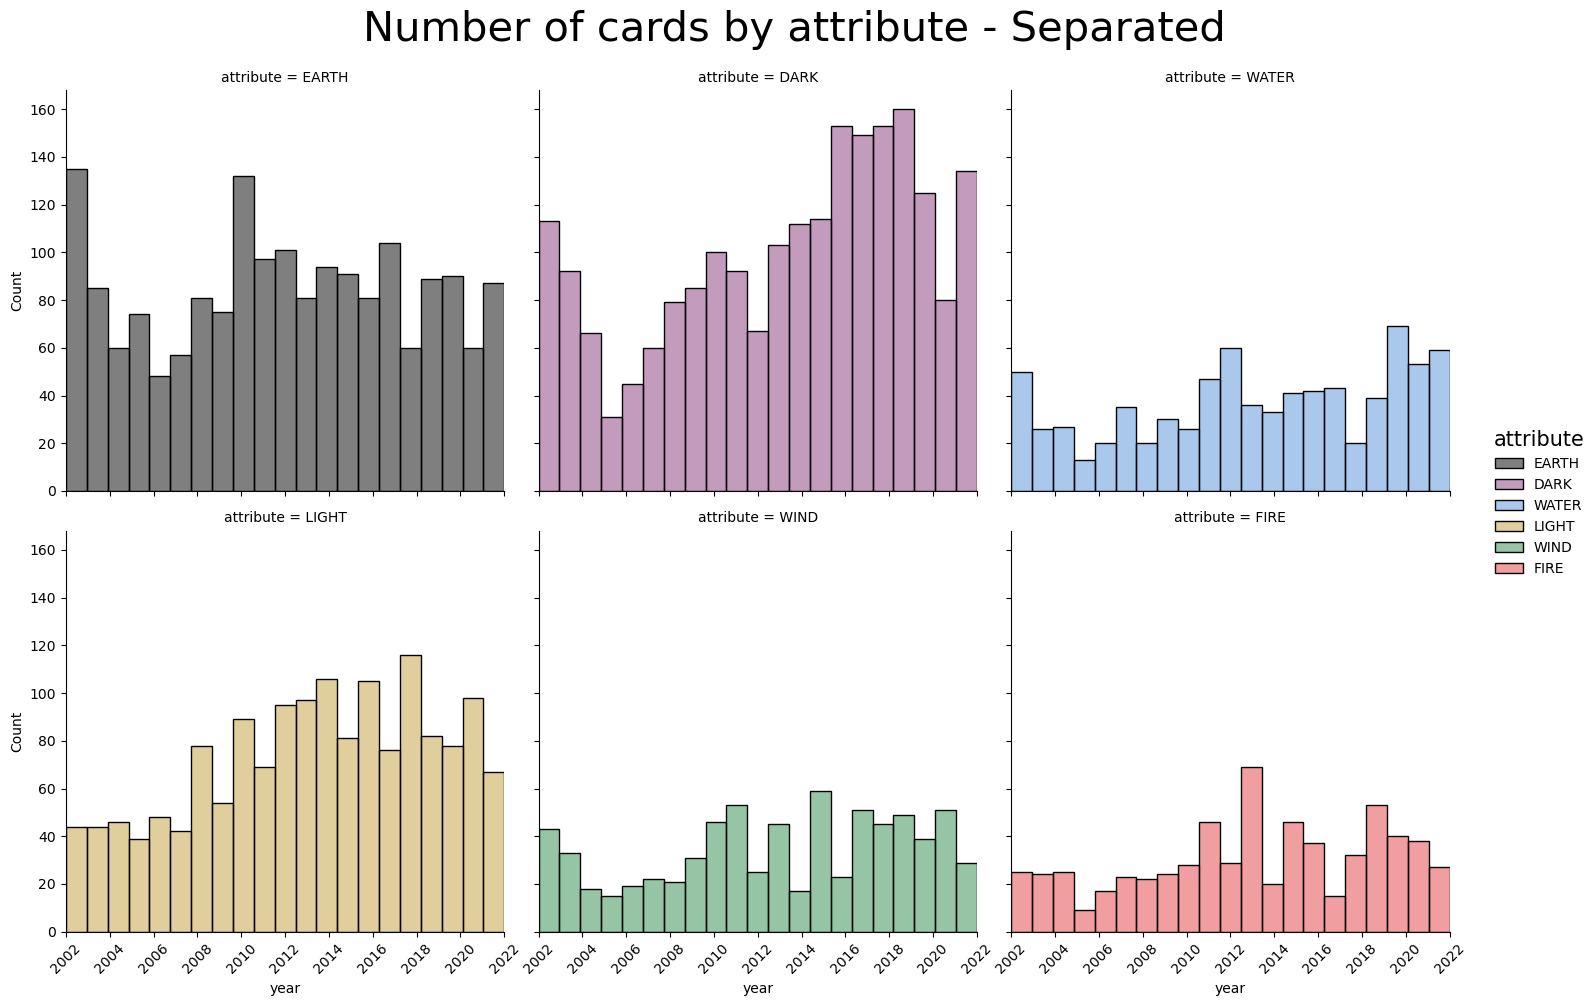

In [18]:
g = sns.displot(
    data=attr_by_year[(attr_by_year["year"].between(2002, 2022)) & (attr_by_year["attribute"] != "DIVINE")],
    x="year",
    weights="num_cards",
    hue="attribute",
    palette=["black", "#89387b", "#5592d8", "#c3a03b", "#2f8c4c", "#e23e40"],
    col="attribute",
    col_wrap=3,
    kind="hist",
    bins=21,
)

for ax in g.axes.flat:
    ax.margins(x=0)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=11))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Number of cards by attribute - Separated", fontsize=30)
plt.setp(g._legend.get_title(), fontsize=15)
plt.show()

Now this one is much better.

The plot above informs us that EARTH and DARK started off with more cards than the other attributes. DARK continued at the top for most of the years and has grown a significant lead in the recent past. EARTH seems to be in a downward trend since a big spike in 2010. LIGHT received a lot of support after starting off with even less cards than WATER. The other attributes haven't seen much action, with WATER being the only one that seemingly can compete for a spot at the top of the chart. 

It seems that there is an aim to balance the number of cards released. After an increase in support in one year, there is a decrease in the following year or two (except for DARK). We can check this by plotting the total number of monster cards released yearly.

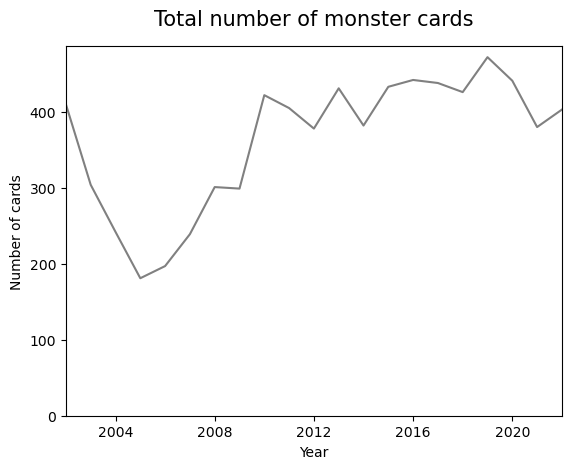

In [19]:
total_by_year = attr_by_year.groupby("year")["num_cards"].sum().reset_index()

sns.lineplot(data=total_by_year[total_by_year["year"].between(2002, 2022)], x="year", y="num_cards", color="grey")
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
ax.tick_params(axis="both", which="major", labelsize=10)
ax.set_ylim(ymin=0)
ax.margins(x=0)

ax.set_title("Total number of monster cards", fontsize=15, pad=15)
ax.set_ylabel("Number of cards")
ax.set_xlabel("Year")

plt.show()

It seems that since 2010 the aim is to release about 400 cards a year.

### What are some of the most loved/hated cards?

In order to answer this question we'll rely on the YGOPRODeck's upvotes/downvotes. Should be quite simple.

Top 10 most loved cards


name  upvotes  downvotes  \
2033                                Black Luster Soldier     2608         11   
16181                                      Dark Magician     1614        138   
21467                               Dragon Master Knight     1533          9   
24867      Black Luster Soldier - Envoy of the Beginning     1507         16   
18671               Black Luster Soldier - Super Soldier     1269          5   
26454  Black Luster Soldier - Envoy of the Evening Tw...     1129          7   
3498                               Slifer the Sky Dragon      682         64   
4373                                             Raigeki      558         10   
769                                          Smile World      468        125   
30422                             Blue-Eyes White Dragon      423        154   

        card_id  
2033    5405694  
16181  46986414  
21467  62873545  
24867  72989439  
18671  54484652  
26454  77498348  
3498   10000020  
4373   12580477  
769     2099841  
30422  89631139

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  if __name__ == "__main__":


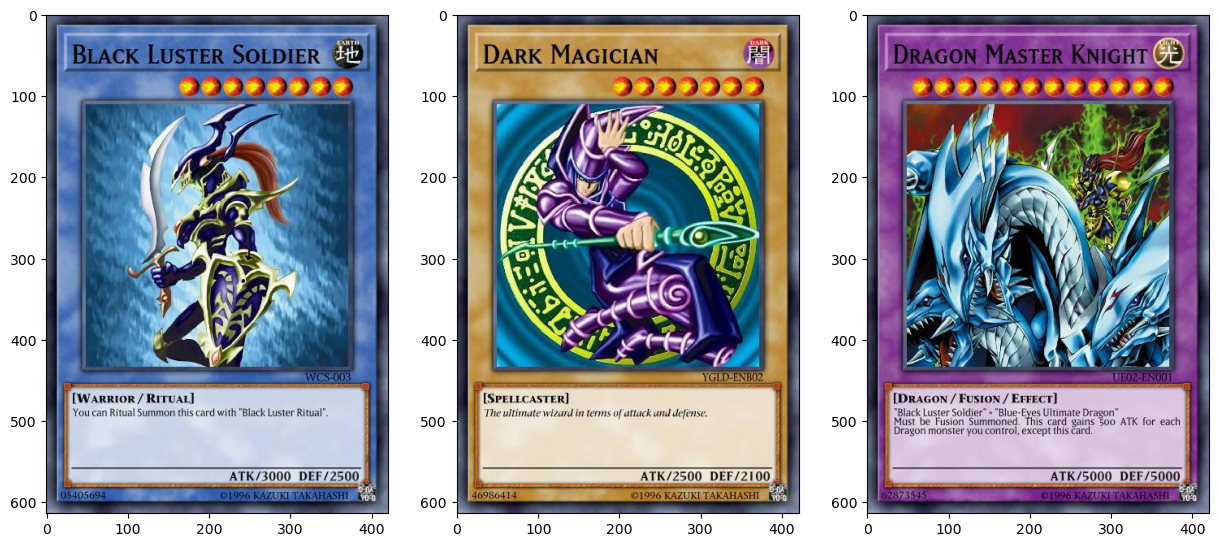

In [20]:
most_loved_df = df_unique[["name", "upvotes", "downvotes", "card_id"]].sort_values("upvotes", ascending=False).head(10)
print("Top 10 most loved cards")
display(most_loved_df)

sample_cards = list(most_loved_df["card_id"])

fig, ax = plt.subplots(1, 3, figsize=(15, 30))
for idx, card_id in enumerate(sample_cards[:3]):
    ax[idx].imshow(plt.imread(f'https://images.ygoprodeck.com/images/cards/{card_id}.jpg', format="jpeg"))

As expected, *Dark Magician* is in the top cut. *Blue Eyes* is also in the top 10, but apart from the upvotes it has a surprising amount of downvotes, not quite sure why. Looking at the results I wasn't aware that *Black Luster Soldier* had such a fanbase in YGOPRODeck. Not only it claims the top stop but it also has 3 other retrained version in the list.

Now let's check the least loved cards

Top 10 most loved cards


name  upvotes  downvotes   card_id
21109               Imperial Order       45        533  61740673
30084  True King of All Calamities       39        196  88581108
30422       Blue-Eyes White Dragon      423        154  89631139
3949                Cannon Soldier        8        144  11384280
16181                Dark Magician     1614        138  46986414
769                    Smile World      468        125   2099841
26101                  Mystic Mine      191        111  76375976
24516        Magical Musketeer Max       29        111  71791814
11827     "A" Cell Breeding Device      118        110  34541863
17361         Crystron Halqifibrax      139        109  50588353

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  if __name__ == "__main__":


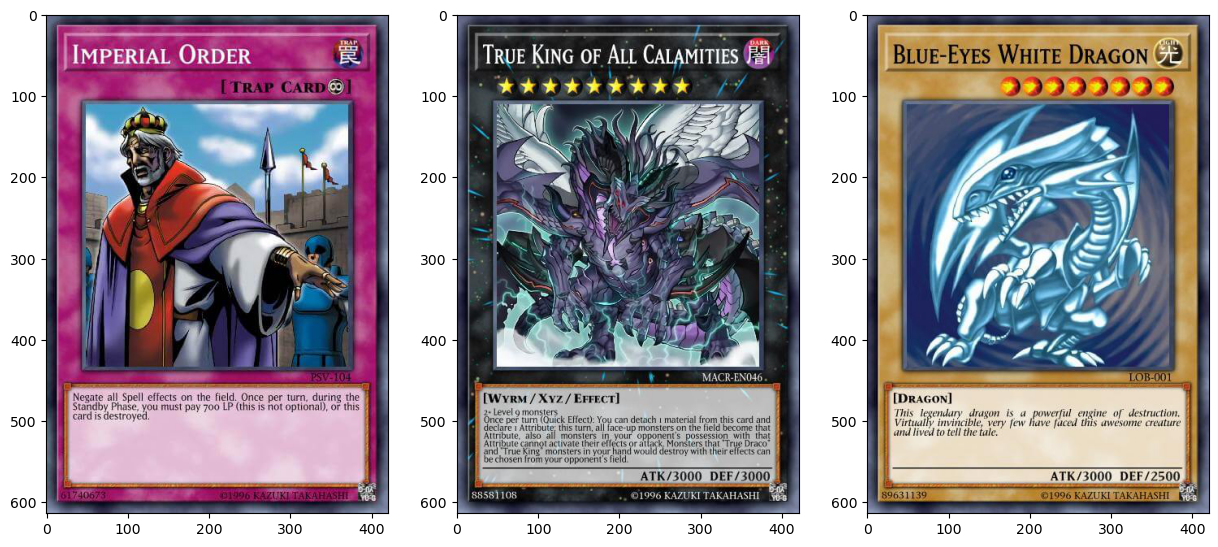

In [21]:
least_loved_df = df_unique[["name", "upvotes", "downvotes", "card_id"]].sort_values("downvotes", ascending=False).head(10)
print("Top 10 most loved cards")
display(least_loved_df)

sample_cards = list(least_loved_df["card_id"])

fig, ax = plt.subplots(1, 3, figsize=(15, 30))
for idx, card_id in enumerate(sample_cards[:3]):
    ax[idx].imshow(plt.imread(f'https://images.ygoprodeck.com/images/cards/{card_id}.jpg', format="jpeg"))

The top two cards in the list are both banned and it makes a lot of sense for them to be the most hated. They both partially stop your opponnent from playing the game. The problem is that your opponnent can also use them against you. *Dark Magician* and *Blue Eyes* being there doesn't really make that much sense, which hints that the metric used (absolute number of upvotes/downvotes) isn't so great. Let's change the metric and compare the results

In [22]:
upvotes_df = df_unique[["name", "upvotes", "downvotes", "card_id"]]
upvotes_df["votes"] = upvotes_df["upvotes"] + upvotes_df["downvotes"]
upvotes_df["upvote_ratio"] = upvotes_df["upvotes"] / upvotes_df["votes"]

print("Top 10 most loved (>= 100 votes)")
display(upvotes_df.loc[upvotes_df["votes"] >= 100, ["name", "upvote_ratio", "card_id"]].sort_values("upvote_ratio", ascending=False).head(10))

print("Top 10 most hated (>= 100 votes)")
display(upvotes_df.loc[upvotes_df["votes"] >= 100, ["name", "upvote_ratio", "card_id"]].sort_values("upvote_ratio", ascending=True).head(10))

Top 10 most loved (>= 100 votes)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


name  upvote_ratio  \
13854                                   Skydive Scorcher      1.000000   
28773                            Number 39: Utopia Roots      1.000000   
31345              Black Luster Soldier - Sacred Soldier      1.000000   
18671               Black Luster Soldier - Super Soldier      0.996075   
20752                         Elemental HERO Plasma Vice      0.996032   
2033                                Black Luster Soldier      0.995800   
21467                               Dragon Master Knight      0.994163   
26454  Black Luster Soldier - Envoy of the Evening Tw...      0.993838   
7988                                 Contrast HERO Chaos      0.992537   
11524                                       V Salamander      0.990385   

        card_id  
13854  40522482  
28773  84124261  
31345  92510265  
18671  54484652  
20752  60493189  
2033    5405694  
21467  62873545  
26454  77498348  
7988   23204029  
11524  33725002

Top 10 most hated (>= 100 votes)


name  upvote_ratio   card_id
3949                             Cannon Soldier      0.052632  11384280
21109                            Imperial Order      0.077855  61740673
30084               True King of All Calamities      0.165957  88581108
24516                     Magical Musketeer Max      0.207143  71791814
7350   Master Peace, the True Dracoslaying King      0.207407  21377582
20191                      Anti-Spell Fragrance      0.303030  58921041
17996                   Number S0: Utopic ZEXAL      0.343511  52653092
11827                  "A" Cell Breeding Device      0.517544  34541863
24460                               Time Wizard      0.544304  71625222
17361                      Crystron Halqifibrax      0.560484  50588353

Well, the black luster soldiers continue to be well represented with a good upvote ratio. I'm not familiar with some of the cards in the most loved list, but I don't see anything wrong. The most hated list makes much more sense now, with a bunch of cards that are hard to counterplay, with most being currently banned.

### When did special summoning started gaining popularity?

The two most common ways to summon a monster in YGO are normal and special summoning. At the beginning special summoning was hard to pull off, requiring multiple cards or a previous setup: something truly special. Nowadays special summoning is as easy as it gets, with single cards being able to lead to dozens of special summons.

To investigate when this started hapenning, we'll analyze the card effects in our data.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


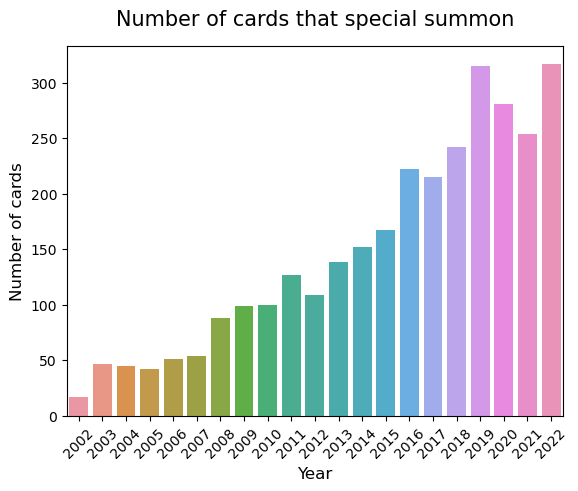

In [23]:
special_summon_text = ["Special Summon this card", "Special Summon 1", "Special Summon them", "Special Summon a", "Fusion Summon 1", "Ritual Summon 1", "Xyz Summon 1", "Link Summon 1"]
special_summon_df = df_unique[df_unique["desc"].str.contains("|".join(special_summon_text))]
special_summon_df["year"] = special_summon_df["first_print"].dt.year

sns.countplot(x="year", data=special_summon_df[special_summon_df["year"] < 2023])
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Number of cards", fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_title("Number of cards that special summon", fontsize=15, pad=15)
plt.show()

There is clearly an upward trend, but mostly a smooth one. Apart from some years like 2002, 2008, 2016, 2019 and 2022 where there was a significant spike, the year-to-year increase was mild. But things seem to have picked up at 2008.